# Predicted Outputs

[Link](https://platform.openai.com/docs/guides/predicted-outputs)

* **Predicted** **Outputs** enable you to speed up API responses from Chat Completions when many of the output tokens are known ahead of time. 
* This is most common when you are regenerating a text or code file with minor modifications. 
* You can provide your prediction using the **prediction** **request** **parameter** in Chat Completions.
* The **latency** gains of Predicted Outputs are even **greater** when you use **streaming** for API responses. 


**CONSIDERATIONS:**
* When providing a **prediction**, any tokens provided that are not part of the final completion are still **charged** at completion token rates. See the rejected_prediction_tokens property of the usage object to see how many tokens are not used in the final response.
* `max_completion_tokens` is NOT supported
* tools (`function calling` is NOT supported)

In [12]:
from openai import OpenAI, AsyncOpenAI
from dotenv import load_dotenv
import json
from textwrap import dedent
import os
load_dotenv()
async_client = AsyncOpenAI(api_key=os.getenv("OPENAI_API_KEY"))
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))



# Test Functionality

In [27]:
chit_chat_prompt = "Identify user inputs that involve casual conversation or general small talk"
end_call_prompt = "If the user wants to finish the call"

domain_questions_summary = "How to address questions related to customer repair requests, invoices, rejected invoices, pricing issues, contract details, malfunctioning petrol cards, vehicle tax calculations, car rental invoices, and warranty insurance coverage?"
domain_prompt = f"If the user wants to know about {domain_questions_summary} at Volkswagen Leasing or general information about the company"

intent_detection_prompt = f"""Classify the following user message into one of the following intents:

1. ChitChat: {chit_chat_prompt}
2. Domain: {domain_prompt}
3. EndCall: {end_call_prompt}
4. Action.GatherDataFromUser: Trigger to collect data from the user, but not if it's just an answer to a previous question from the assistant.
5. Action.IssueTypeIdentification: Trigger to identify the type of user's issue.
6. Action.CarBreakDownTowingService: Trigger if the customer's car has broke down and need a towing service.
7. Action.WarrantyInsuranceContractual: Trigger if the customer has a question about a contractual component of warranty insurance. Do NOT trigger if it's about an unpaid or rejected invoice.

If you don't know the intent, don't tell me, only return the word 'Domain'.
If user wants to know about something within Volkswagen Leasing context, usually it's 'Domain'.
Return a full intent name as a response with the intent classified. Don't say anything else.
If you return one of the available actions, return "Action.NAME_OF_THE_ACTION" as a response.
"""

In [40]:
prediction="ChitChatDomainEndCallAction.GatherDataFromUserAction.IssueTypeIdentificationAction.CarBreakDownTowingServiceAction.WarrantyInsuranceContractual"

In [43]:
stream = await client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "system",
            "content": intent_detection_prompt
        },
        {
            "role": "user",
            "content": "Hello, I want to you to gather some data from me"
        }
    ],
    prediction={
        "type": "content",
        "content": prediction
    },
    stream=True,
    stream_options={"include_usage": True},
)

async for chunk in stream:
    if chunk.usage:
        print(chunk.usage.completion_tokens_details)
    elif chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="\n")



Action
.G
ather
Data
From
User
CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=30)


In [31]:
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "system",
            "content": intent_detection_prompt
        },
        {
            "role": "user",
            "content": "Hello, I need help with my car, I got a flat tire"
        }
    ],
    prediction={
        "type": "content",
        "content": "Action.CarBreakDownTowingService"
    },
)

print(response.choices[0].message.content)  
print(response.usage.completion_tokens_details)

Action.CarBreakDownTowingService
CompletionTokensDetails(accepted_prediction_tokens=7, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=47)


In [20]:
input_json = json.dumps({
    "name": "<candidate_name>",
    "email": "<candidate_email>",
    "phone": "<candidate_phone>",
    "message": "<message>"
})

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "system",
            "content": "Your role is to fill out the following form with the candidate's information. You need to fill it out with random values, but they should make sense"
        },
        {
            "role": "user",
            "content": dedent(input_json)
        }
    ],
    prediction={
        "type": "content",
        "content": input_json
    },
)

print(response.choices[0].message.content)  
print(response.usage.completion_tokens_details)

{"name": "Alice Johnson", "email": "alice.johnson@example.com", "phone": "555-0234-678", "message": "Hello, I am interested in the position you posted. I have over 5 years of experience in project management and believe my skills align well with the job requirements. Looking forward to the opportunity to discuss further. Thank you!"}
CompletionTokensDetails(accepted_prediction_tokens=3, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=25)


In [77]:
code = """class User {
  firstName: string = "";
  lastName: string = "";
  username: string = "";
}

export default User;
"""

refactor_prompt = """
Replace the "username" property with an "email" property. Respond only 
with code, and with no markdown formatting.
"""

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "user",
            "content": refactor_prompt
        },
        {
            "role": "user",
            "content": code
        }
    ],
    prediction={
        "type": "content",
        "content": code
    }
)

print(completion)
print(completion.choices[0].message.content)
print(len(completion.choices[0].message.content))
for i,idx in enumerate(completion.choices[0].message.content):
    print(idx, i)
print()
print(completion.usage.completion_tokens_details)
print(completion.usage.prompt_tokens_details)

ChatCompletion(id='chatcmpl-Adzik3SPwe42MHM324TrA0SAl7zqZ', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='class User {\n  firstName: string = "";\n  lastName: string = "";\n  email: string = "";\n}\n\nexport default User;', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1734095410, model='gpt-4o-2024-08-06', object='chat.completion', service_tier=None, system_fingerprint='fp_a79d8dac1f', usage=CompletionUsage(completion_tokens=39, prompt_tokens=81, total_tokens=120, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=18, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=10), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))
class User {
  firstName: string = "";
  lastName: string = "";
  email: string = "";
}

export default User;
109
c 0
l 1
a 2
s 3
s 4
  5
U 6
s 7
e 8
r 9
  10
{ 11

 12
  13
  14
f 15
i 16
r 17
s 18
t 19

# Test Latencies

## Data Gathering with JSON Mode

In [22]:
import time

def fill_out_form(use_predicted_outputs: bool):
    input_json = json.dumps({
        "name": "<candidate_name>",
        "email": "<candidate_email>",
        "phone": "<candidate_phone>",
        "message": "<message>"
    })

    prediction = { "type": "content", "content": input_json } if use_predicted_outputs else None

    start_time = time.time()
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": "Your role is to fill out the following form with the candidate's information. You need to fill it out with random values, but they should make sense"
            },
            {
                "role": "user",
                "content": dedent(input_json)
            }
        ],
        prediction=prediction
    )
    latency = time.time() - start_time
    #print(response.choices[0].message.content)  
    #print(response.usage.completion_tokens_details)
    return latency

In [23]:
latencies = {
    "predicted_outputs": [],
    "no_predicted_outputs": []
}
NUM_ITERATIONS = 20

for _ in range(NUM_ITERATIONS):
    latencies["predicted_outputs"].append(fill_out_form(use_predicted_outputs=True))
    latencies["no_predicted_outputs"].append(fill_out_form(use_predicted_outputs=False))



Predicted_outputs Latencies:
  Average: 1.9559 seconds
  Minimum: 1.0256 seconds
  Maximum: 4.5484 seconds
  Standard Deviation: 0.9010 seconds

No_predicted_outputs Latencies:
  Average: 3.1016 seconds
  Minimum: 1.0227 seconds
  Maximum: 18.0119 seconds
  Standard Deviation: 3.6680 seconds



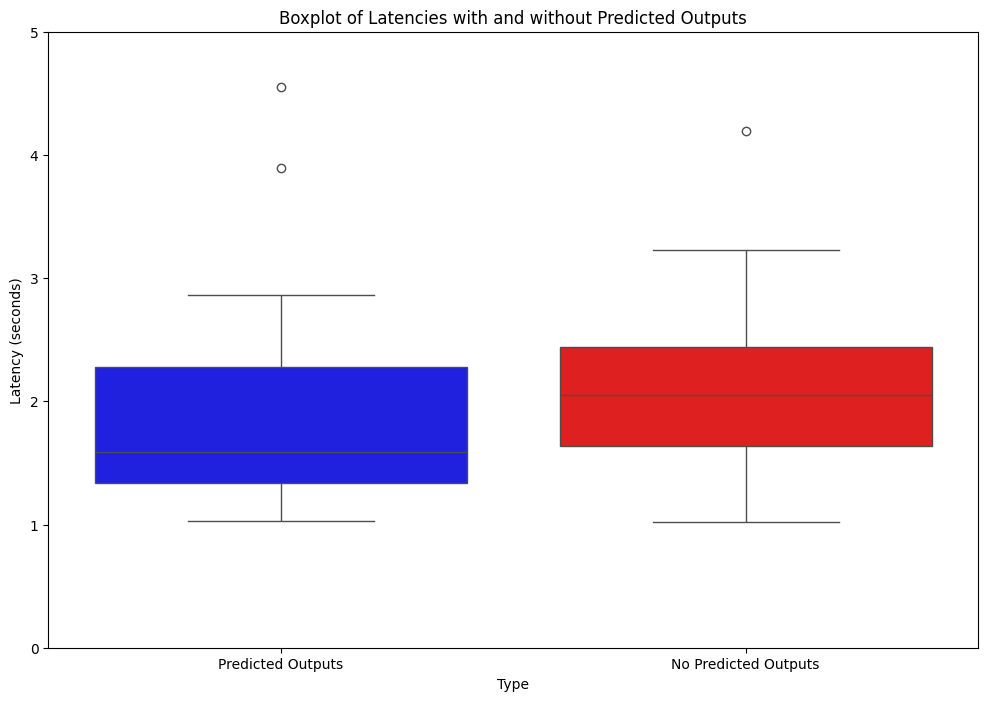

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate statistics
predicted_outputs_latencies = latencies["predicted_outputs"]
no_predicted_outputs_latencies = latencies["no_predicted_outputs"]

stats = {
    "predicted_outputs": {
        "avg": np.mean(predicted_outputs_latencies),
        "min": np.min(predicted_outputs_latencies),
        "max": np.max(predicted_outputs_latencies),
        "std": np.std(predicted_outputs_latencies)
    },
    "no_predicted_outputs": {
        "avg": np.mean(no_predicted_outputs_latencies),
        "min": np.min(no_predicted_outputs_latencies),
        "max": np.max(no_predicted_outputs_latencies),
        "std": np.std(no_predicted_outputs_latencies)
    }
}

# Print statistics
for key, value in stats.items():
    print(f"{key.capitalize()} Latencies:")
    print(f"  Average: {value['avg']:.4f} seconds")
    print(f"  Minimum: {value['min']:.4f} seconds")
    print(f"  Maximum: {value['max']:.4f} seconds")
    print(f"  Standard Deviation: {value['std']:.4f} seconds")
    print()

# Plot boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=[predicted_outputs_latencies, no_predicted_outputs_latencies], palette=["blue", "red"])
plt.xticks([0, 1], ["Predicted Outputs", "No Predicted Outputs"])
plt.xlabel("Type")
plt.ylabel("Latency (seconds)")
plt.ylim(0, 5)
plt.title("Boxplot of Latencies with and without Predicted Outputs")
plt.show()

## Intent Detection

Latency Comparison: With vs Without Prediction
With Prediction - Avg: 0.40s, Min: 0.30s, Max: 0.54s, Std: 0.05
Without Prediction - Avg: 0.41s, Min: 0.28s, Max: 1.02s, Std: 0.12


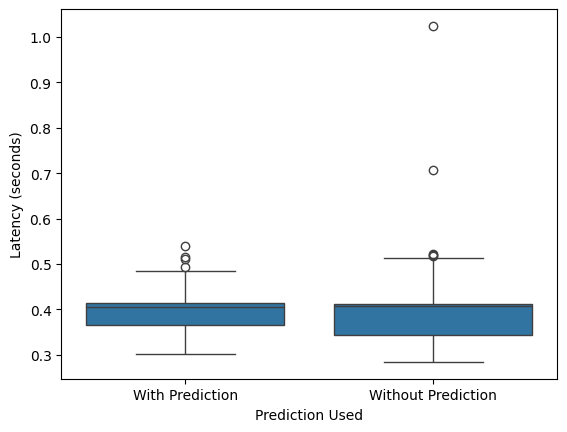

Total Accepted Prediction Tokens: [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
Total Rejected Prediction Tokens: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]


In [32]:
import asyncio
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Generate 50 user queries (25 Domain Intent and 25 random)
domain_queries = [
    "Can you tell me about the warranty details?",
    "How do I handle a rejected invoice?",
    "What are the pricing details for car rentals?",
    "Can you explain the malfunctioning petrol cards?",
    "How do I calculate vehicle taxes?",
    "What is the process for addressing repair requests?",
    "Who do I contact for issues related to insurance coverage?",
    "Can I get a copy of my contract?",
    "What do I need for warranty claims?",
    "How do I know if my invoice was approved?",
    "Can you help me with rejected invoices?",
    "What is the Volkswagen leasing number?",
    "What’s the warranty period for this model?",
    "Can you assist with petrol card issues?",
    "What do I do for a malfunctioning card?",
    "How do I handle contract questions?",
    "Can you explain the pricing breakdown?",
    "What steps are required for an invoice correction?",
    "How do I address an unpaid invoice?",
    "What’s included in the insurance coverage?",
    "Can you clarify tax details for this vehicle?",
    "Who handles repair claims?",
    "How do I report a vehicle issue?",
    "Can you guide me about car rentals?",
    "What’s the process for warranty extensions?",
]
random_queries = [
    "Hello, how are you?",
    "I need to end this call now.",
    "Can you gather my details?",
    "The car broke down; what should I do?",
    "What is the process for a towing service?",
    "Can you explain this invoice issue?",
    "What’s the best insurance for me?",
    "How do I update my contract details?",
    "Can you help me with road assistance?",
    "Where can I find more information about this model?",
    "What are my options for repair services?",
    "How do I file an insurance claim?",
    "Can you send me the contact details for customer support?",
    "How do I resolve a technical issue with my car?",
    "Can you assist me with a malfunctioning device?",
    "What’s the procedure for warranty renewals?",
    "Who do I talk to for further assistance?",
    "Can you assist me with troubleshooting?",
    "What’s the process for canceling my contract?",
    "How do I check my contract status?",
    "Can you assist me with pricing plans?",
    "Where can I locate tax-related information?",
    "Can you guide me about invoice corrections?",
    "What’s the next step for repair assistance?",
    "Can I schedule a callback?",
]
user_queries = domain_queries + random_queries
random.shuffle(user_queries)

# Lists to store results
latency_with_prediction = []
latency_without_prediction = []
accepted_prediction_tokens = []
rejected_prediction_tokens = []

# Async function to simulate client calls
def run_completions_test():
    for use_prediction in [True, False]:
        for query in user_queries:
            start_time = time.time()

            prediction = {"type": "content", "content": "Domain"} if use_prediction else None

            stream = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": intent_detection_prompt},
                    {"role": "user", "content": query},
                ],
                prediction=prediction,
                stream=True,
                stream_options={"include_usage": True},
            )

            for chunk in stream:
                if chunk.usage:
                    if use_prediction:
                        accepted_prediction_tokens.append(
                            chunk.usage.completion_tokens_details.accepted_prediction_tokens
                        )
                        rejected_prediction_tokens.append(
                            chunk.usage.completion_tokens_details.rejected_prediction_tokens
                        )

            latency = time.time() - start_time
            if use_prediction:
                latency_with_prediction.append(latency)
            else:
                latency_without_prediction.append(latency)

# Run the test
run_completions_test()

# Calculate statistics
stats_with_prediction = {
    "avg": sum(latency_with_prediction) / len(latency_with_prediction),
    "min": min(latency_with_prediction),
    "max": max(latency_with_prediction),
    "std": pd.Series(latency_with_prediction).std(),
}

stats_without_prediction = {
    "avg": sum(latency_without_prediction) / len(latency_without_prediction),
    "min": min(latency_without_prediction),
    "max": max(latency_without_prediction),
    "std": pd.Series(latency_without_prediction).std(),
}

# Plot the results
data = pd.DataFrame(
    {
        "Latency (seconds)": latency_with_prediction + latency_without_prediction,
        "Prediction Used": ["With Prediction"] * len(latency_with_prediction) + ["Without Prediction"] * len(latency_without_prediction),
    }
)
sns.boxplot(x="Prediction Used", y="Latency (seconds)", data=data)
plt.title("Latency Comparison: With vs Without Prediction")
print(f"With Prediction - Avg: {stats_with_prediction['avg']:.2f}s, Min: {stats_with_prediction['min']:.2f}s, Max: {stats_with_prediction['max']:.2f}s, Std: {stats_with_prediction['std']:.2f}\nWithout Prediction - Avg: {stats_without_prediction['avg']:.2f}s, Min: {stats_without_prediction['min']:.2f}s, Max: {stats_without_prediction['max']:.2f}s, Std: {stats_without_prediction['std']:.2f}")
plt.show()

# Display accepted and rejected prediction token statistics
print("Total Accepted Prediction Tokens:", (accepted_prediction_tokens))
print("Total Rejected Prediction Tokens:", (rejected_prediction_tokens))


## Domain Questions

In [10]:
import pandas as pd
import time

persona_prompt_style = "Be polite and professional"
persona_prompt_strategy = "Be helpful and informative"
persona_use_persona = True

df_knowledgebase = pd.read_csv('vw_en_knowledgebase.csv')

In [7]:
extra_prompt ="""1. If the context provides a clear answer:
- Respond concisely and directly, using all the information from the context.
 
2. If the context is related but doesn't fully answer the question:
- Provide the relevant information from the context.
- Clearly state that the answer is incomplete and explain what additional information might be needed.
 
3. If the context is unrelated or there's no relevant information:
- Clearly state that you don't have the specific information to answer the question.
 
4. In all cases:
- Maintain a natural, conversational tone suitable for voice interaction.
- Keep responses concise and to the point.
"""

In [1]:
def get_system_prompt(context: list[str], persona_prompt_style: str, persona_prompt_strategy: str, persona_use_persona: bool, extra_prompt: str) -> str:
    context_stringified = "\n".join(context)
    return f"""You're a customer service agent.
    Use the following pieces of context to answer the following user message.
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
 
    {f'Follow the following style of conversation: {persona_prompt_style}' if persona_prompt_style and persona_use_persona else ''}
    {f'Use the following strategy: {persona_prompt_strategy}' if persona_prompt_strategy and persona_use_persona else ''}
 
    Context:
    {context_stringified}
 
    {extra_prompt}
    """

In [56]:
def run_latency_tests(enable_predicted_outputs: bool, latencies: dict, num_iterations: int = 1, fail_prediction_on_purpose: bool = False):
    if enable_predicted_outputs:
        mode="predicted_outputs"
    else:
        mode="no_predicted_outputs"
    for _ in range(num_iterations):
        for _, df_row in df_knowledgebase.iterrows():
            question = df_row['Question']
            answer= df_row['Answer']
            context = f"Question: {question} => Answer: {answer}"
            system_prompt = get_system_prompt([context], persona_prompt_style, persona_prompt_strategy, persona_use_persona, extra_prompt)
            print(context)
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "assistant", "content": "Hello, I am the digital assistant of Volkswagen Financial Services. How can I help you today?"},
                {"role": "user", "content": question},
            ]
            if enable_predicted_outputs:
                if fail_prediction_on_purpose:
                    prediction = "dummy_prediction"
                else:
                    prediction = answer.strip()
            else:
                prediction = None

            start_time = time.time()
            time_to_first_chunk = None
            stream = client.chat.completions.create(
                model="gpt-4o",
                messages=messages,
                temperature=0.1,
                max_tokens=256,
                #response_format={"type": response_format},
                stream=True,
                stream_options={"include_usage": True},
                prediction={"type":"content","content":prediction},
            )
            llm_answer = ""
            for chunk in stream:
                if chunk.usage:
                    print(f"\t{chunk.usage.completion_tokens_details}")
                    latencies[mode]["accepted_prediction_tokens"].append(chunk.usage.completion_tokens_details.accepted_prediction_tokens)
                    latencies[mode]["rejected_prediction_tokens"].append(chunk.usage.completion_tokens_details.rejected_prediction_tokens)
                    if chunk.usage.completion_tokens_details.rejected_prediction_tokens > 0:
                        print(f"\t\t Predicted answer: {prediction}")
                        print(f"\t\t Actual answer: {llm_answer}")

                else:
                    if not time_to_first_chunk:
                        time_to_first_chunk = time.time() - start_time
                    llm_answer += chunk.choices[0].delta.content if chunk.choices[0].delta.content else ""
                    #print(chunk.choices[0].delta.content)
            total_latency=  time.time() - start_time

            latencies[mode]["time_to_first_chunk"].append(time_to_first_chunk)
            latencies[mode]["total_latency"].append(total_latency)


In [45]:
latencies = {
    "predicted_outputs":{
        "time_to_first_chunk":[],
        "total_latency":[],
        "accepted_prediction_tokens":[],
        "rejected_prediction_tokens":[]

    },
    "no_predicted_outputs":{
        "time_to_first_chunk":[],
        "total_latency":[],        
        "accepted_prediction_tokens":[],
        "rejected_prediction_tokens":[],
    }
}

run_latency_tests(enable_predicted_outputs=True, latencies=latencies, num_iterations=3)
run_latency_tests(enable_predicted_outputs=False, latencies=latencies, num_iterations=3)

Question: I have a question about an open repair request for one of our customers. => Answer: We would like to advise you to use the request process and the systems provided by us (iSport). This will document your response to the rejected enquiry.
	CompletionTokensDetails(accepted_prediction_tokens=31, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0)
Question: I have a question about an outstanding invoice for one of our customers. => Answer: Have you used our HIS system and/or the invoice clarification tool in iSport? If not, we would ask you to use the systems provided by us. This will document your comments on the rejected invoice. This also allows you to submit evidence for invoice clarification.
	CompletionTokensDetails(accepted_prediction_tokens=39, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=12)
		 Predicted answer: Have you used our HIS system and/or the invoice clarification tool in iSport? If not, we would ask you to use the systems provide

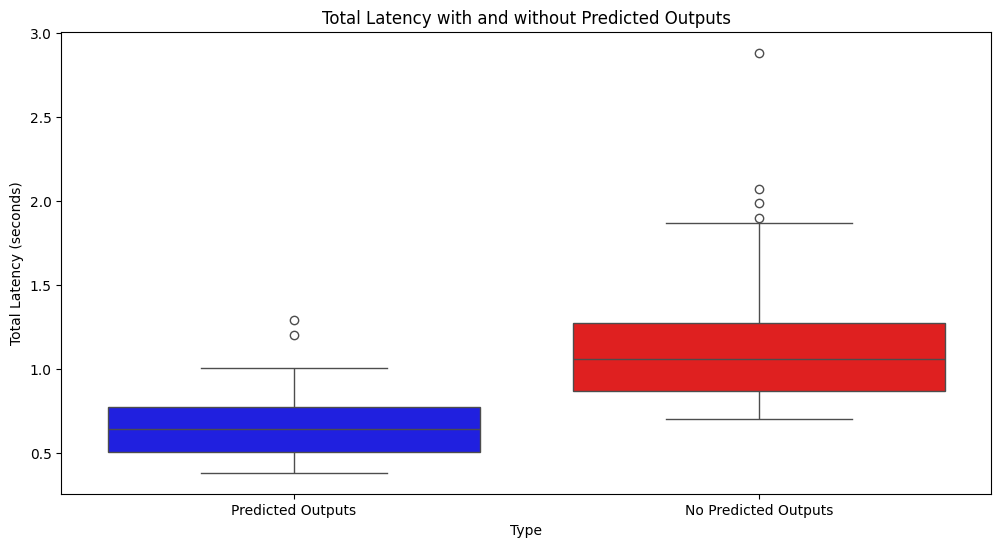

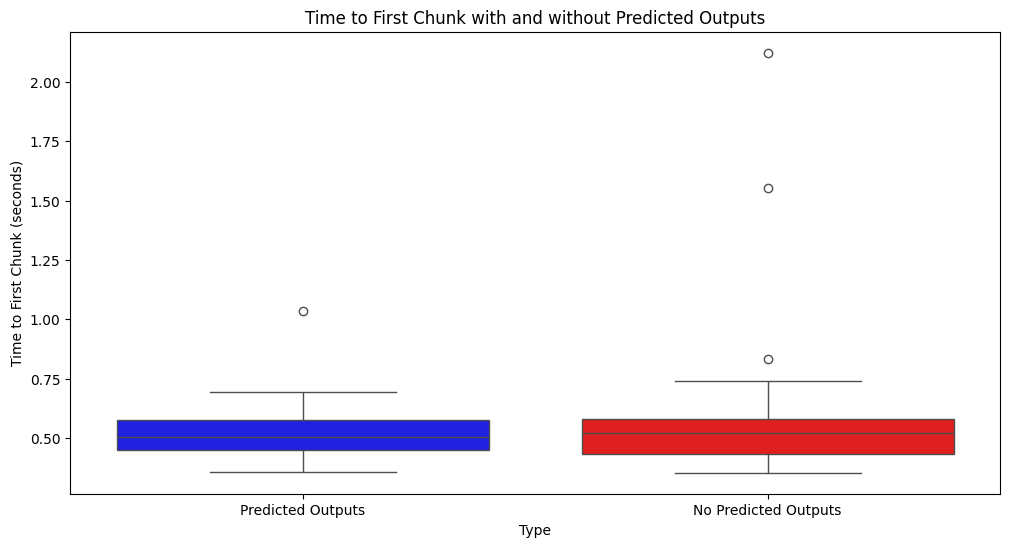

Predicted_outputs Total Latency:
  Average: 0.6654 seconds
  Minimum: 0.3826 seconds
  Maximum: 1.2929 seconds
  Standard Deviation: 0.2064 seconds

Predicted_outputs Time to First Chunk:
  Average: 0.5252 seconds
  Minimum: 0.3572 seconds
  Maximum: 1.0364 seconds
  Standard Deviation: 0.1205 seconds

No_predicted_outputs Total Latency:
  Average: 1.1726 seconds
  Minimum: 0.7042 seconds
  Maximum: 2.8801 seconds
  Standard Deviation: 0.4548 seconds

No_predicted_outputs Time to First Chunk:
  Average: 0.5833 seconds
  Minimum: 0.3535 seconds
  Maximum: 2.1236 seconds
  Standard Deviation: 0.3162 seconds



In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Boxplot for total latency
plt.figure(figsize=(12, 6))
sns.boxplot(data=[latencies["predicted_outputs"]["total_latency"], latencies["no_predicted_outputs"]["total_latency"]], palette=["blue", "red"])
plt.xticks([0, 1], ["Predicted Outputs", "No Predicted Outputs"])
plt.xlabel("Type")
plt.ylabel("Total Latency (seconds)")
plt.title("Total Latency with and without Predicted Outputs")
plt.show()

# Boxplot for time to first chunk
plt.figure(figsize=(12, 6))
sns.boxplot(data=[latencies["predicted_outputs"]["time_to_first_chunk"], latencies["no_predicted_outputs"]["time_to_first_chunk"]], palette=["blue", "red"])
plt.xticks([0, 1], ["Predicted Outputs", "No Predicted Outputs"])
plt.xlabel("Type")
plt.ylabel("Time to First Chunk (seconds)")
plt.title("Time to First Chunk with and without Predicted Outputs")
plt.show()

# Calculate and print statistics
for mode in ["predicted_outputs", "no_predicted_outputs"]:
    total_latency = latencies[mode]["total_latency"]
    time_to_first_chunk = latencies[mode]["time_to_first_chunk"]
    
    print(f"{mode.capitalize()} Total Latency:")
    print(f"  Average: {np.mean(total_latency):.4f} seconds")
    print(f"  Minimum: {np.min(total_latency):.4f} seconds")
    print(f"  Maximum: {np.max(total_latency):.4f} seconds")
    print(f"  Standard Deviation: {np.std(total_latency):.4f} seconds")
    print()
    
    print(f"{mode.capitalize()} Time to First Chunk:")
    print(f"  Average: {np.mean(time_to_first_chunk):.4f} seconds")
    print(f"  Minimum: {np.min(time_to_first_chunk):.4f} seconds")
    print(f"  Maximum: {np.max(time_to_first_chunk):.4f} seconds")
    print(f"  Standard Deviation: {np.std(time_to_first_chunk):.4f} seconds")
    print()

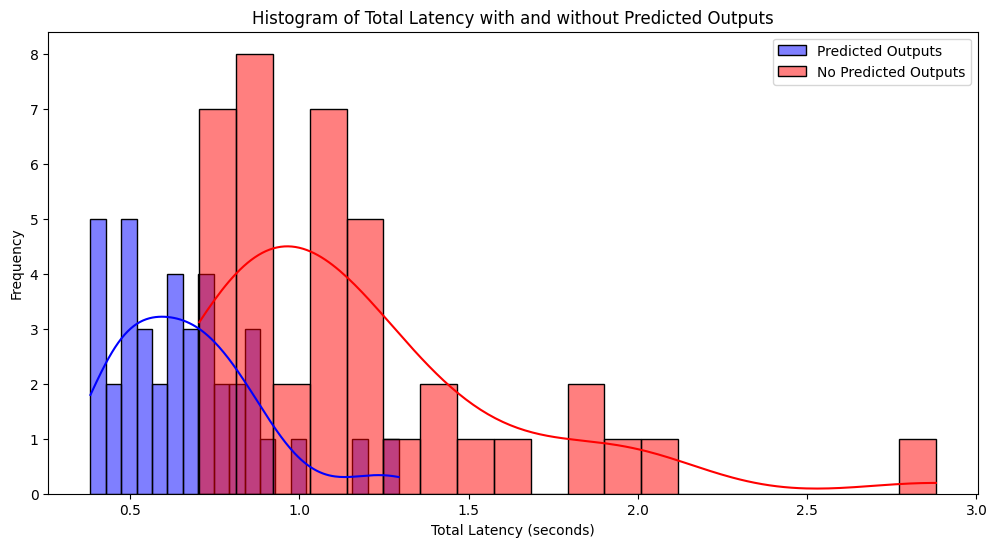

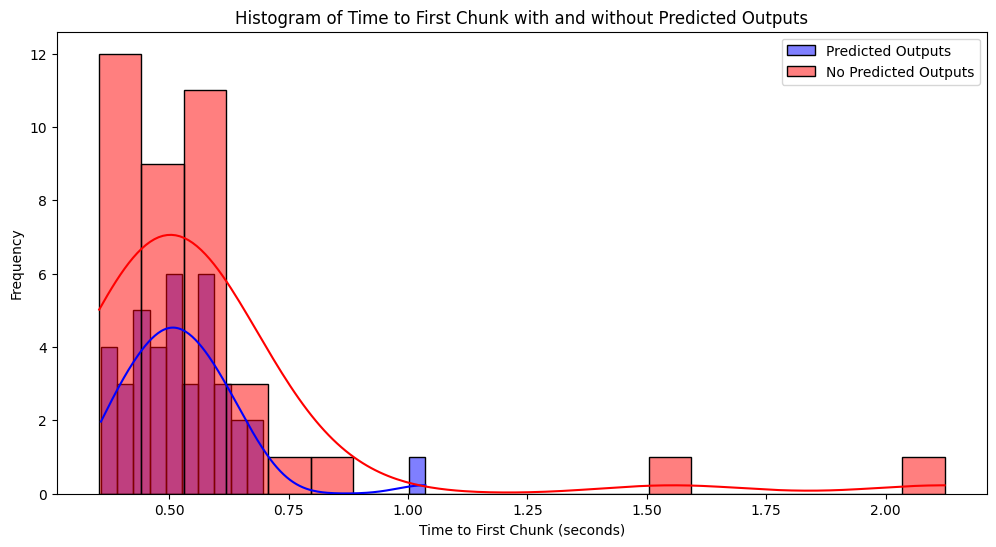

In [47]:
# Histplot for total latency
plt.figure(figsize=(12, 6))
sns.histplot(latencies["predicted_outputs"]["total_latency"], color="blue", label="Predicted Outputs", kde=True, bins=20)
sns.histplot(latencies["no_predicted_outputs"]["total_latency"], color="red", label="No Predicted Outputs", kde=True, bins=20)
plt.xlabel("Total Latency (seconds)")
plt.ylabel("Frequency")
plt.title("Histogram of Total Latency with and without Predicted Outputs")
plt.legend()
plt.show()

# Histplot for time to first chunk
plt.figure(figsize=(12, 6))
sns.histplot(latencies["predicted_outputs"]["time_to_first_chunk"], color="blue", label="Predicted Outputs", kde=True, bins=20)
sns.histplot(latencies["no_predicted_outputs"]["time_to_first_chunk"], color="red", label="No Predicted Outputs", kde=True, bins=20)
plt.xlabel("Time to First Chunk (seconds)")
plt.ylabel("Frequency")
plt.title("Histogram of Time to First Chunk with and without Predicted Outputs")
plt.legend()
plt.show()

In [48]:
# Calculate total accepted and rejected prediction tokens
total_accepted_tokens = sum(latencies["predicted_outputs"]["accepted_prediction_tokens"])
total_rejected_tokens = sum(latencies["predicted_outputs"]["rejected_prediction_tokens"])

# Calculate percentages
total_tokens = total_accepted_tokens + total_rejected_tokens
accepted_percentage = (total_accepted_tokens / total_tokens) * 100 if total_tokens > 0 else 0
rejected_percentage = (total_rejected_tokens / total_tokens) * 100 if total_tokens > 0 else 0

# Print the percentages
print(f"Accepted Prediction Tokens: {accepted_percentage:.2f}%")
print(f"Rejected Prediction Tokens: {rejected_percentage:.2f}%")

Accepted Prediction Tokens: 96.85%
Rejected Prediction Tokens: 3.15%


In [57]:
latencies_failed_prediction = {
    "predicted_outputs":{
        "time_to_first_chunk":[],
        "total_latency":[],
        "accepted_prediction_tokens":[],
        "rejected_prediction_tokens":[]

    },
    "no_predicted_outputs":{
        "time_to_first_chunk":[],
        "total_latency":[],        
        "accepted_prediction_tokens":[],
        "rejected_prediction_tokens":[],
    }
}

run_latency_tests(enable_predicted_outputs=True, latencies=latencies_failed_prediction, num_iterations=3, fail_prediction_on_purpose=True)
run_latency_tests(enable_predicted_outputs=False, latencies=latencies_failed_prediction, num_iterations=3,  fail_prediction_on_purpose=True)

Question: I have a question about an open repair request for one of our customers. => Answer: We would like to advise you to use the request process and the systems provided by us (iSport). This will document your response to the rejected enquiry.
	CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=2)
		 Predicted answer: dummy_prediction
		 Actual answer: We would like to advise you to use the request process and the systems provided by us (iSport). This will document your response to the rejected enquiry. If you need further assistance, please let me know.
Question: I have a question about an outstanding invoice for one of our customers. => Answer: Have you used our HIS system and/or the invoice clarification tool in iSport? If not, we would ask you to use the systems provided by us. This will document your comments on the rejected invoice. This also allows you to submit evidence for invoice clarification.
	CompletionT

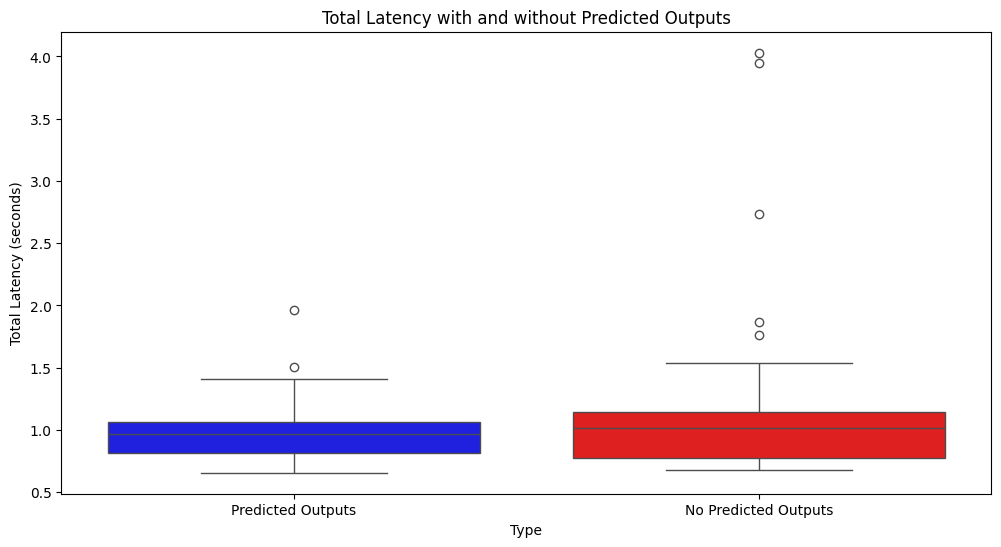

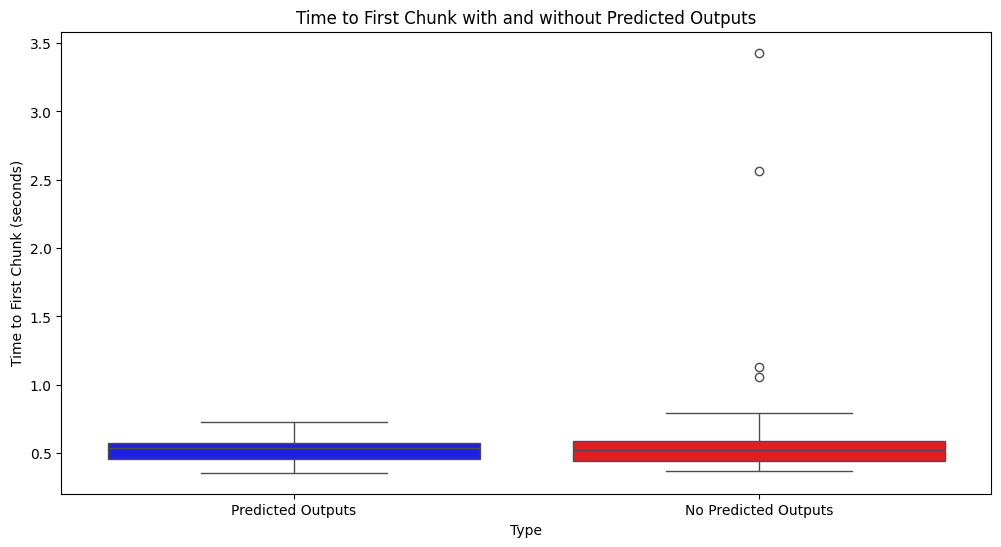

Predicted_outputs Total Latency:
  Average: 0.9957 seconds
  Minimum: 0.6558 seconds
  Maximum: 1.9623 seconds
  Standard Deviation: 0.2537 seconds

Predicted_outputs Time to First Chunk:
  Average: 0.5201 seconds
  Minimum: 0.3564 seconds
  Maximum: 0.7258 seconds
  Standard Deviation: 0.0895 seconds

No_predicted_outputs Total Latency:
  Average: 1.1945 seconds
  Minimum: 0.6769 seconds
  Maximum: 4.0298 seconds
  Standard Deviation: 0.7602 seconds

No_predicted_outputs Time to First Chunk:
  Average: 0.6661 seconds
  Minimum: 0.3688 seconds
  Maximum: 3.4302 seconds
  Standard Deviation: 0.5716 seconds



In [58]:
latencies=latencies_failed_prediction
# Boxplot for total latency
plt.figure(figsize=(12, 6))
sns.boxplot(data=[latencies["predicted_outputs"]["total_latency"], latencies["no_predicted_outputs"]["total_latency"]], palette=["blue", "red"])
plt.xticks([0, 1], ["Predicted Outputs", "No Predicted Outputs"])
plt.xlabel("Type")
plt.ylabel("Total Latency (seconds)")
plt.title("Total Latency with and without Predicted Outputs")
plt.show()

# Boxplot for time to first chunk
plt.figure(figsize=(12, 6))
sns.boxplot(data=[latencies["predicted_outputs"]["time_to_first_chunk"], latencies["no_predicted_outputs"]["time_to_first_chunk"]], palette=["blue", "red"])
plt.xticks([0, 1], ["Predicted Outputs", "No Predicted Outputs"])
plt.xlabel("Type")
plt.ylabel("Time to First Chunk (seconds)")
plt.title("Time to First Chunk with and without Predicted Outputs")
plt.show()

# Calculate and print statistics
for mode in ["predicted_outputs", "no_predicted_outputs"]:
    total_latency = latencies[mode]["total_latency"]
    time_to_first_chunk = latencies[mode]["time_to_first_chunk"]
    
    print(f"{mode.capitalize()} Total Latency:")
    print(f"  Average: {np.mean(total_latency):.4f} seconds")
    print(f"  Minimum: {np.min(total_latency):.4f} seconds")
    print(f"  Maximum: {np.max(total_latency):.4f} seconds")
    print(f"  Standard Deviation: {np.std(total_latency):.4f} seconds")
    print()
    
    print(f"{mode.capitalize()} Time to First Chunk:")
    print(f"  Average: {np.mean(time_to_first_chunk):.4f} seconds")
    print(f"  Minimum: {np.min(time_to_first_chunk):.4f} seconds")
    print(f"  Maximum: {np.max(time_to_first_chunk):.4f} seconds")
    print(f"  Standard Deviation: {np.std(time_to_first_chunk):.4f} seconds")
    print()

In [59]:
# Calculate total accepted and rejected prediction tokens
total_accepted_tokens = sum(latencies_failed_prediction["predicted_outputs"]["accepted_prediction_tokens"])
total_rejected_tokens = sum(latencies_failed_prediction["predicted_outputs"]["rejected_prediction_tokens"])

# Calculate percentages
total_tokens = total_accepted_tokens + total_rejected_tokens
accepted_percentage = (total_accepted_tokens / total_tokens) * 100 if total_tokens > 0 else 0
rejected_percentage = (total_rejected_tokens / total_tokens) * 100 if total_tokens > 0 else 0

# Print the percentages
print(f"Accepted Prediction Tokens: {accepted_percentage:.2f}%")
print(f"Rejected Prediction Tokens: {rejected_percentage:.2f}%")

Accepted Prediction Tokens: 0.00%
Rejected Prediction Tokens: 100.00%
